In [57]:
# Configure notebook
run_name = "earthy-dew-137"
output_dir = "results"
config_path = "configs/mnist_vae_l1.yaml"
epoch = 21
training_labels = "0 2 3 6 7 8 9"


In [37]:
# Load embeddings
from yacs.config import CfgNode
from efir.checkpointer import Checkpointer
from efir.utils import CodeBlock, setup_logger, load_config, cfg_node_to_dict
import numpy as np

cfg = load_config(config_path)
device = cfg.DEVICE

checkpointer = Checkpointer(output_dir + "/" + run_name)
results_file = checkpointer.get_inference_results_path(epoch)

resultz = np.load(results_file, allow_pickle=True)

data_tTrue = np.concatenate(resultz["data_tTrue"], axis=0)
labels_tTrue = np.concatenate(resultz["labels_tTrue"], axis=0)
yhat_tTrue = np.concatenate(resultz["yhat_tTrue"], axis=0)
mu_tTrue = np.concatenate(resultz["mu_tTrue"], axis=0)
log_var_tTrue = np.concatenate(resultz["log_var_tTrue"], axis=0)

data_tFalse = np.concatenate(resultz["data_tFalse"], axis=0)
labels_tFalse = np.concatenate(resultz["labels_tFalse"], axis=0)
yhat_tFalse = np.concatenate(resultz["yhat_tFalse"], axis=0)
mu_tFalse = np.concatenate(resultz["mu_tFalse"], axis=0)
log_var_tFalse = np.concatenate(resultz["log_var_tFalse"], axis=0)

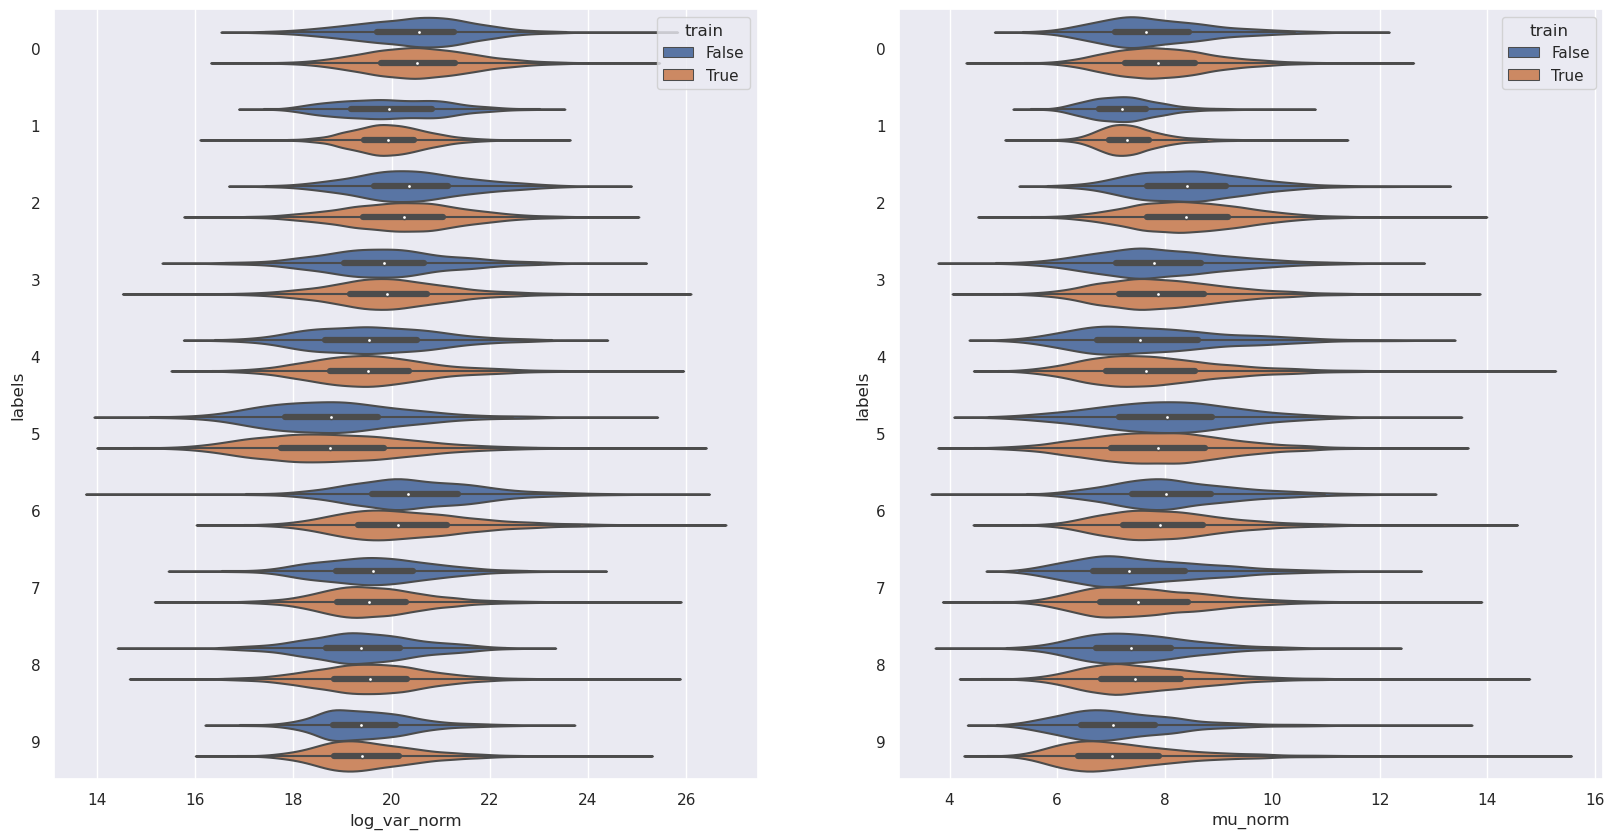

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

log_var_tTrue_norm = np.linalg.norm(log_var_tTrue, axis=1)
log_var_tFalse_norm = np.linalg.norm(log_var_tFalse, axis=1)

mu_tTrue_norm = np.linalg.norm(mu_tTrue, axis=1)
mu_tFalse_norm = np.linalg.norm(mu_tFalse, axis=1)

df = pd.DataFrame.from_dict(
    {
        "log_var_norm": np.concatenate([log_var_tTrue_norm, log_var_tFalse_norm]),
        "mu_norm": np.concatenate([mu_tTrue_norm, mu_tFalse_norm]),
        "labels": np.concatenate([labels_tTrue, labels_tFalse]).astype(str),
        "train": np.array(([True] * labels_tTrue.shape[0]) + ([False] * labels_tFalse.shape[0])),
    }
)

df[df.train].head()

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
sns.violinplot(df, x="log_var_norm", y="labels", hue="train", order=[str(x) for x in range(10)], ax=axes[1])

sns.violinplot(df, x="mu_norm", y="labels", hue="train", order=[str(x) for x in range(10)], ax=axes[2])

plt.show()

In [62]:
%%time
# lower dim of embedding
from sklearn.manifold import TSNE

tsne = TSNE()
mu_tTrue_tsne = tsne.fit_transform(mu_tTrue)

tsne = TSNE()
mu_tFalse_tsne = tsne.fit_transform(mu_tFalse)

CPU times: user 18min 36s, sys: 9.15 s, total: 18min 46s
Wall time: 3min 55s


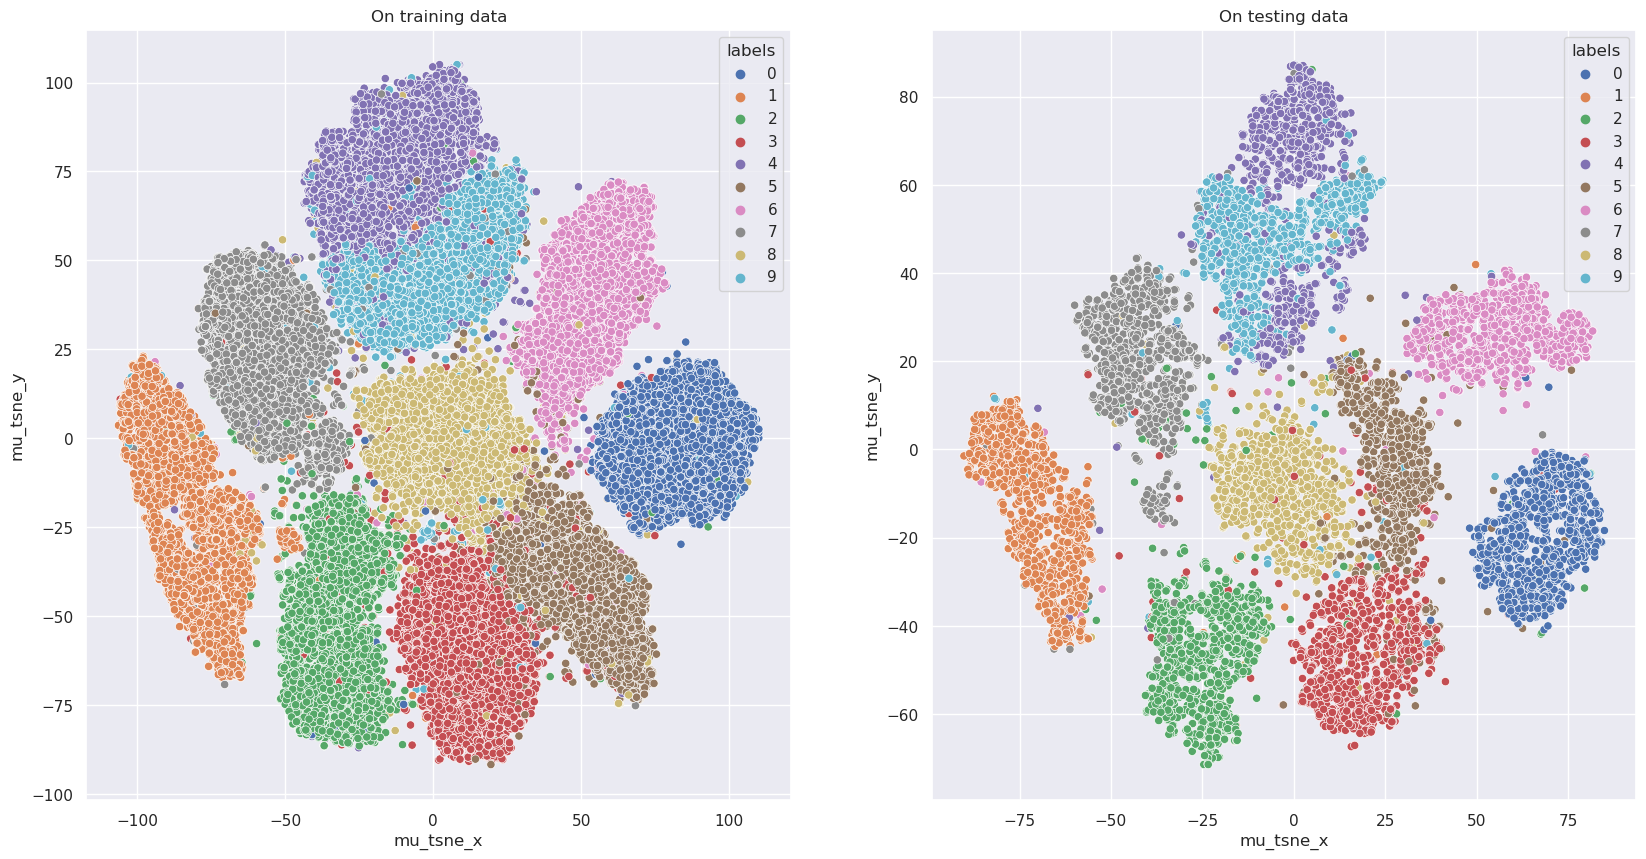

In [68]:
mu_tsne = np.concatenate([mu_tTrue_tsne, mu_tFalse_tsne])
df = pd.DataFrame.from_dict(
    {
        "mu_tsne_x": mu_tsne[:, 0],
        "mu_tsne_y": mu_tsne[:, 1],
        "labels": np.concatenate([labels_tTrue, labels_tFalse]).astype(str),
        "train": np.array(([True] * labels_tTrue.shape[0]) + ([False] * labels_tFalse.shape[0])),
    }
)


fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
sns.scatterplot(df[df.train], x="mu_tsne_x", y="mu_tsne_y", hue="labels", hue_order=[str(x) for x in range(10)], ax=axes[0])
axes[0].set_title("On training data")
sns.scatterplot(df[~df.train], x="mu_tsne_x", y="mu_tsne_y", hue="labels", hue_order=[str(x) for x in range(10)], ax=axes[1])
axes[1].set_title("On testing data")
plt.show()

In [ ]:
# Interpolating embeddings